# Viewing images of Varchamp wells
**Author:** Jessica Ewald <br>

The purpose of this script is to query image names by batch, plate, well, site, & channel, download from AWS, and render in a notebook. This will be useful for quick visual sanity checks.

In [8]:
# Imports
import polars as pl
import numpy as np
from sh import aws
import os
from skimage.io import imread
from matplotlib import pyplot as plt
import matplotlib as mpl

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Define mapping between simple names and folder names
batch_dict = {"B4A3R1": "2023-12-15_B4A3R1", 
              "B6A3R2": "2023-12-21_B6A3R2", 
              "B7A1R1": "2024_01_23_Batch_7",
              "B8A1R2": "2024_02_06_Batch_8"}

letter_dict = {
    "A": "01",
    "B": "02",
    "C": "03",
    "D": "04",
    "E": "05",
    "F": "06",
    "G": "07",
    "H": "08",
    "I": "09",
    "J": "10",
    "K": "11",
    "L": "12",
    "M": "13",
    "N": "14",
    "O": "15",
    "P": "16",
}

plate_dict = {
    "B4-P1T1": "2023-12-15_B4A3R1_P1T1__2023-12-15T08_49_02-Measurement1",
    "B4-P1T2": "2023-12-15_B4A3R1_P1T2__2023-12-15T10_35_54-Measurement1",
    "B4-P1T3": "2023-12-18_B4A3R1_P1T3__2023-12-18T08_29_45-Measurement1",
    "B4-P1T4": "2023-12-18_B4A3R1_P1T4__2023-12-18T10_17_07-Measurement1",
    
    "B6-P1T1": "2023-12-21_B6A3R2_P1T1__2023-12-21T08_28_37-Measurement1",
    "B6-P1T2": "2023-12-21_B6A3R2_P1T2__2023-12-21T10_11_34-Measurement1",
    "B6-P1T3": "2023-12-21_B6A3R2_P1T3__2023-12-21T11_57_14-Measurement1",
    "B6-P1T4": "2023-12-21_B6A3R2_P1T4__2023-12-21T13_40_04-Measurement1",
    
    "B7A1R1_P1": {"T1": "2024_01_17_B7A1R1_P1T1__2024_01_17T08_35_58_Measurement_1",
                  "T2": "2024_01_17_B7A1R1_P1T2__2024_01_17T10_13_45_Measurement_1",
                  "T3": "2024_01_17_B7A1R1_P1T3__2024_01_17T11_58_08_Measurement_1",
                  "T4": "2024_01_17_B7A1R1_P1T4__2024_01_17T13_45_14_Measurement_1"},
    
    "B7A1R1_P2": {"T1": "2024_01_17_B7A1R1_P2T1__2024_01_17T15_33_09_Measurement_1",
                  "T2": "2024_01_17_B7A1R1_P2T2__2024_01_18T08_25_01_Measurement_1",
                  "T3": "2024_01_17_B7A1R1_P2T3__2024_01_18T10_47_36_Measurement_1",
                  "T4": "2024_01_17_B7A1R1_P2T4__2024_01_18T12_48_20_Measurement_1"},
        
    "B7A1R1_P3": {"T1": "2024_01_18_B7A1R1_P3T1__2024_01_18T14_27_08_Measurement_1",
                  "T2": "2024_01_19_B7A1R1_P3T2__2024_01_19T08_23_30_Measurement_1",
                  "T3": "2024_01_19_B7A1R1_P3T3__2024_01_19T10_01_45_Measurement_1",
                  "T4": "2024_01_19_B7A1R1_P3T4__2024_01_19T12_00_10_Measurement_1"},
            
    "B7A1R1_P4": {"T1": "2024_01_19_B7A1R1_P4T1__2024_01_19T13_50_55_Measurement_1",
                  "T2": "2024_01_23_B7A1R1_P4T2__2024_01_23T10_13_00_Measurement_1",
                  "T3": "2024_01_22_B7A1R1_P4T3__2024_01_22T08_37_41_Measurement_1",
                  "T4": "2024_01_22_B7A1R1_P4T4__2024_01_22T10_27_16_Measurement_1"},
    
    "B7A2R1_P1": {"T1": "2024_01_22_B7A2R1_P1T1__2024_01_22T12_13_13_Measurement_1",
                  "T2": "2024_01_22_B7A2R1_P1T2__2024_01_22T13_52_24_Measurement_1",
                  "T3": "2024_01_22_B7A2R1_P1T3__2024_01_22T15_29_31_Measurement_1",
                  "T4": "2024_01_23_B7A2R1_P1T4__2024_01_23T08_28_07_Measurement_1"},
    
    "B7-P1T1": "2024_01_17_B7A1R1_P1T1__2024_01_17T08_35_58_Measurement_1",
    "B7-P1T2": "2024_01_17_B7A1R1_P1T2__2024_01_17T10_13_45_Measurement_1",
    "B7-P1T3": "2024_01_17_B7A1R1_P1T3__2024_01_17T11_58_08_Measurement_1",
    "B7-P1T4": "2024_01_17_B7A1R1_P1T4__2024_01_17T13_45_14_Measurement_1",
    
    "B7-P3T1": "2024_01_18_B7A1R1_P3T1__2024_01_18T14_27_08_Measurement_1",
    "B7-P3T2": "2024_01_19_B7A1R1_P3T2__2024_01_19T08_23_30_Measurement_1",
    "B7-P3T3": "2024_01_19_B7A1R1_P3T3__2024_01_19T10_01_45_Measurement_1",
    "B7-P3T4": "2024_01_19_B7A1R1_P3T4__2024_01_19T12_00_10_Measurement_1",
    
    "B7-A2T1": "2024_01_22_B7A2R1_P1T1__2024_01_22T12_13_13_Measurement_1",
    "B7-A2T2": "2024_01_22_B7A2R1_P1T2__2024_01_22T13_52_24_Measurement_1",
    "B7-A2T3": "2024_01_22_B7A2R1_P1T3__2024_01_22T15_29_31_Measurement_1",
    "B7-A2T4": "2024_01_23_B7A2R1_P1T4__2024_01_23T08_28_07_Measurement_1",
    
    "B8-P1T1": "2024_01_31_B8A1R2_P1T1__2024_01_31T10_11_57_Measurement_1",
    "B8-P1T2": "2024_01_31_B8A1R2_P1T2__2024_01_31T08_35_51_Measurement_2",
    "B8-P1T3": "2024_01_31_B8A1R2_P1T3__2024_01_31T12_09_14_Measurement_1",
    "B8-P1T4": "2024_01_31_B8A1R2_P1T4__2024_01_31T14_02_18_Measurement_2",
    
    "B8-P3T1": "2024_02_02_B8A1R2_P3T1__2024_02_02T08_32_30_Measurement_2",
    "B8-P3T2": "2024_02_02_B8A1R2_P3T2__2024_02_02T10_08_05_Measurement_1",
    "B8-P3T3": "2024_02_02_B8A1R2_P3T3__2024_02_02T11_58_46_Measurement_2",
    "B8-P3T4": "2024_02_02_B8A1R2_P3T4__2024_02_02T13_51_50_Measurement_1",
    
    "B8-A2T1": "2024_02_05_B8A2R2_P1T1__2024_02_05T13_23_28_Measurement_1",
    "B8-A2T2": "2024_02_05_B8A2R2_P1T2__2024_02_05T15_18_32_Measurement_1",
    "B8-A2T3": "2024_02_06_B8A2R2_P1T3__2024_02_06T08_23_49_Measurement_1",
    "B8-A2T4": "2024_02_06_B8A2R2_P1T4__2024_02_06T10_18_16_Measurement_1"
}

channel_dict = {
    "DAPI": "1",
    "GFP": "2",
    "AGP": "3",
    "Mito": "4",
    "Brightfield1": "5",
    "Brightfield2": "6",
    "Brightfield": "7",
}

In [17]:
# Define function for downloading images (if needed) and displaying

def getImages(sel_batch, sel_plate, site, well, sel_channel, intensity_perc, rep="", title=""):
    # construct image name and aws path
    letter = well[0]
    col = well[1:3]
    batch = batch_dict[sel_batch]
    row = letter_dict[letter]
    plate = plate_dict[sel_plate]
    
    if type(plate) == dict:
        plate = plate[rep]

    channel = channel_dict[sel_channel]
        
    if sel_channel == "GFP":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#65fe08"])
    elif sel_channel == "DAPI":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#0000FF"])
    elif sel_channel == "Mito":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#FF0000"]) 
    elif sel_channel == "AGP":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#FFFF00"]) 
    else:
        cmap = "gray"

    img_nm = f"r{row}c{col}f{site}p01-ch{channel}sk1fk1fl1.tiff"

    aws_path = f"s3://cellpainting-gallery/cpg0020-varchamp/broad/images/{batch}/images/{plate}/Images/{img_nm}"
    dgx_path = (
        f"outputs/images/{sel_batch}{rep}/{sel_plate}"
    )

    # construct folder path in DGX
    os.makedirs(dgx_path, exist_ok=True)

    # download image if it doesn't already exist
    if os.path.isfile(f"{dgx_path}/{img_nm}"):
        print("file exists!")
    else:
        aws("s3", "cp", aws_path, f"{dgx_path}/{img_nm}")
        print("downloaded file!")

    # read tiff into numpy array
    img = imread(f"{dgx_path}/{img_nm}", as_gray=True)
    
    plot_label = f"{title} {sel_channel}: {sel_plate}{rep}, {well} - {site}. mean-raw: {'%.2f' % img.flatten().mean()}"
    
    return img, plot_label, cmap


   
def plotAllele(pm, variant, site, channel, intensity, replicate):
    wt = variant.split("_")[0]
    
    wt_well = pm.filter(pl.col("gene_allele") == wt).select("well_position")[0,0]
    var_well = pm.filter(pl.col("gene_allele") == variant).select("well_position")[0,0]
    
    plate = pm.filter(pl.col("gene_allele") == variant).select("plate_map_name")[0,0]

    img_wt, plot_label_wt, cmap = getImages("B7A1R1", plate, site, wt_well, channel, intensity, rep = replicate, title=wt)
    img_var, plot_label_var, cmap = getImages("B7A1R1", plate, site, var_well, channel, intensity, rep = replicate, title=variant)

    # display plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0,0].imshow(img_wt, vmin=np.percentile(img_wt, 100-intensity), vmax=np.percentile(img_wt, intensity), cmap=cmap)
    # axs[0,0].text(20, 40, plot_label_wt, bbox=dict(fill='white', linewidth=1), fontsize=9)
    axs[0,0].axis("off")
    
    axs[1,0].imshow(img_var, vmin=np.percentile(img_wt, 100-intensity), vmax=np.percentile(img_wt, intensity), cmap=cmap)
    # axs[1,0].text(20, 40, plot_label_var, bbox=dict(fill='white', linewidth=1), fontsize=9)
    axs[1,0].axis("off")
    
    axs[0,1].imshow(img_wt, vmin=np.percentile(img_var, 100-intensity), vmax=np.percentile(img_var, intensity), cmap=cmap)
    # axs[0,1].text(20, 40, plot_label_wt, bbox=dict(fill='white', linewidth=1), fontsize=9)
    axs[0,1].axis("off")
    
    axs[1,1].imshow(img_var, vmin=np.percentile(img_var, 100-intensity), vmax=np.percentile(img_var, intensity), cmap=cmap)
    # axs[1,1].text(20, 40, plot_label_var, bbox=dict(fill='white', linewidth=1), fontsize=9)
    axs[1,1].axis("off")
    fig.tight_layout(pad=1)
    plt.show()
    

In [11]:
# Download platemaps
aws_path = f"s3://cellpainting-gallery/cpg0020-varchamp/broad/workspace/metadata/2024_01_23_Batch_7/platemap"
dgx_path = (
    f"/dgx1nas1/storage/data/sam/varchamp/platemaps"
)

B7_plates = ["B7A1R1_P1.txt", "B7A1R1_P2.txt", "B7A1R1_P3.txt", "B7A1R1_P4.txt", "B7A2R1_P1.txt"]
# B8_plates = ["B8A1R2_P1.txt", "B8A1R2_P2.txt", "B8A1R2_P3.txt", "B8A1R2_P4.txt", "B8A2R2_P1.txt"]

pm = pl.DataFrame()
for plate in B7_plates:
    aws_file = f"{aws_path}/{plate}"
    dgx_file = f"{dgx_path}/{plate}"
    
    if not os.path.isfile(dgx_file):
        print("downloading file!")
        aws("s3", "cp", aws_file, dgx_file)
        
    temp_pm = pl.read_csv(dgx_file, separator="\t")
    pm = pl.concat([pm, temp_pm], how="vertical")
        


downloaded file!
downloaded file!


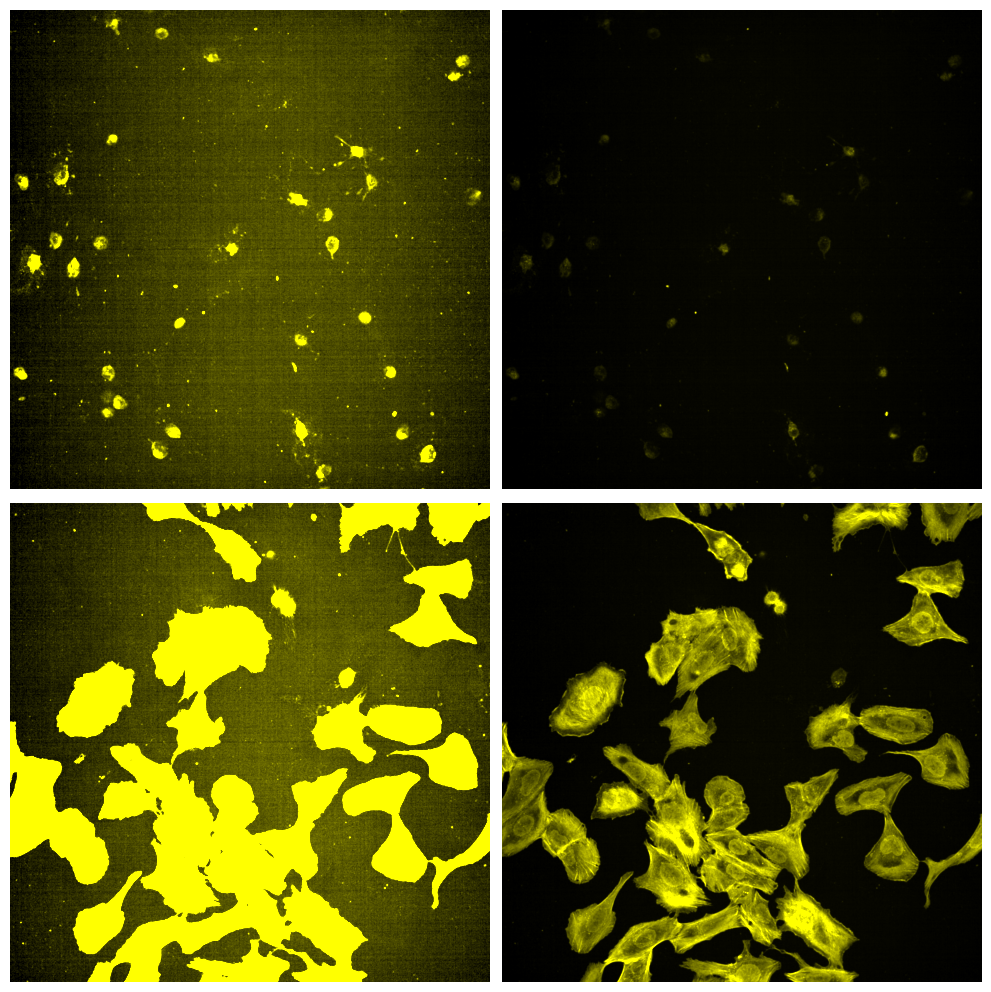

In [72]:
plotAllele(pm, "STXBP1_Arg292Cys", "05", "AGP", 99, "T2")